<a href="https://colab.research.google.com/github/nimeshlal097/TFT-wind-power-prediction/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
import kagglehub
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
import lightning.pytorch as pl # Changed from pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, MAE, RMSE
import torch

warnings.filterwarnings('ignore')
pl.seed_everything(42)

c:\Users\User\anaconda3\envs\tft\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


42

In [2]:
path = kagglehub.dataset_download("mubashirrahim/wind-power-generation-data-forecasting")
data = pd.read_csv(path + "/Location1.csv")

In [3]:
# Parse time column
data['Time'] = pd.to_datetime(data['Time'])
data = data.sort_values('Time').reset_index(drop=True)

# Handle missing values
data = data.ffill().bfill()

print("Data Shape:", data.shape)
print("\nFirst few rows:")
print(data.head())
print("\nData Info:")
print(data.info())

Data Shape: (43800, 10)

First few rows:
                 Time  temperature_2m  relativehumidity_2m  dewpoint_2m  \
0 2017-01-02 00:00:00            28.5                   85         24.5   
1 2017-01-02 01:00:00            28.4                   86         24.7   
2 2017-01-02 02:00:00            26.8                   91         24.5   
3 2017-01-02 03:00:00            27.4                   88         24.3   
4 2017-01-02 04:00:00            27.3                   88         24.1   

   windspeed_10m  windspeed_100m  winddirection_10m  winddirection_100m  \
0           1.44            1.26                146                 162   
1           2.06            3.99                151                 158   
2           1.30            2.78                148                 150   
3           1.30            2.69                 58                 105   
4           2.47            4.43                 58                  84   

   windgusts_10m   Power  
0            1.4  0.1635  
1  

In [4]:
# Hour cyclic features
data['hour'] = data['Time'].dt.hour
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

# Month cyclic features
data['month'] = data['Time'].dt.month
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Day of week cyclic features
data['dayofweek'] = data['Time'].dt.dayofweek
data['dayofweek_sin'] = np.sin(2 * np.pi * data['dayofweek'] / 7)
data['dayofweek_cos'] = np.cos(2 * np.pi * data['dayofweek'] / 7)

print("Cyclic features added!")
print(f"Columns now: {len(data.columns)}")
print(data.head())


Cyclic features added!
Columns now: 19
                 Time  temperature_2m  relativehumidity_2m  dewpoint_2m  \
0 2017-01-02 00:00:00            28.5                   85         24.5   
1 2017-01-02 01:00:00            28.4                   86         24.7   
2 2017-01-02 02:00:00            26.8                   91         24.5   
3 2017-01-02 03:00:00            27.4                   88         24.3   
4 2017-01-02 04:00:00            27.3                   88         24.1   

   windspeed_10m  windspeed_100m  winddirection_10m  winddirection_100m  \
0           1.44            1.26                146                 162   
1           2.06            3.99                151                 158   
2           1.30            2.78                148                 150   
3           1.30            2.69                 58                 105   
4           2.47            4.43                 58                  84   

   windgusts_10m   Power  hour  hour_sin  hour_cos  month  

### CELL 3: ADD LAG FEATURES

In [5]:
lags = [1, 2, 6, 12, 24, 48]

for lag in lags:
    data[f'windspeed_100m_lag{lag}'] = data['windspeed_100m'].shift(lag)
    data[f'Power_lag{lag}'] = data['Power'].shift(lag)

print("Lag features added!")
print(f"New columns: {[col for col in data.columns if 'lag' in col]}")
print(f"Total columns: {len(data.columns)}")

Lag features added!
New columns: ['windspeed_100m_lag1', 'Power_lag1', 'windspeed_100m_lag2', 'Power_lag2', 'windspeed_100m_lag6', 'Power_lag6', 'windspeed_100m_lag12', 'Power_lag12', 'windspeed_100m_lag24', 'Power_lag24', 'windspeed_100m_lag48', 'Power_lag48']
Total columns: 31


### CELL 4: ADD ROLLING FEATURES

In [6]:
windows = [6, 12, 24]

for window in windows:
    data[f'windspeed_100m_roll_mean_{window}'] = data['windspeed_100m'].rolling(window).mean()
    data[f'windspeed_100m_roll_std_{window}'] = data['windspeed_100m'].rolling(window).std()
    data[f'Power_roll_mean_{window}'] = data['Power'].rolling(window).mean()

print("Rolling features added!")
print(f"Rolling feature columns: {[col for col in data.columns if 'roll' in col]}")

# Drop NaN rows
data = data.dropna().reset_index(drop=True)

print(f"\nFinal data shape: {data.shape}")
print(data.head())

Rolling features added!
Rolling feature columns: ['windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6', 'Power_roll_mean_6', 'windspeed_100m_roll_mean_12', 'windspeed_100m_roll_std_12', 'Power_roll_mean_12', 'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24', 'Power_roll_mean_24']



Final data shape: (43752, 40)
                 Time  temperature_2m  relativehumidity_2m  dewpoint_2m  \
0 2017-01-04 00:00:00            33.7                   95         32.3   
1 2017-01-04 01:00:00            32.6                   95         31.2   
2 2017-01-04 02:00:00            32.3                   93         30.6   
3 2017-01-04 03:00:00            31.9                   91         29.4   
4 2017-01-04 04:00:00            28.7                   88         25.5   

   windspeed_10m  windspeed_100m  winddirection_10m  winddirection_100m  \
0           4.84            8.32                288                 290   
1           5.95           10.11                278                 279   
2           5.85            9.93                278                 279   
3           7.26           11.81                277                 278   
4           7.41           11.93                272                 274   

   windgusts_10m   Power  ...  Power_lag48  windspeed_100m_roll_mea

### CELL 5: NORMALIZE DATA

In [7]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

print(f"Numeric columns: {numeric_cols}")
print(f"Total numeric columns: {len(numeric_cols)}")

scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

print("\nData normalized!")
print(data.head())
print("\nNormalized data statistics:")
print(data[numeric_cols].describe())

Numeric columns: ['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'windspeed_10m', 'windspeed_100m', 'winddirection_10m', 'winddirection_100m', 'windgusts_10m', 'Power', 'hour', 'hour_sin', 'hour_cos', 'month', 'month_sin', 'month_cos', 'dayofweek', 'dayofweek_sin', 'dayofweek_cos', 'windspeed_100m_lag1', 'Power_lag1', 'windspeed_100m_lag2', 'Power_lag2', 'windspeed_100m_lag6', 'Power_lag6', 'windspeed_100m_lag12', 'Power_lag12', 'windspeed_100m_lag24', 'Power_lag24', 'windspeed_100m_lag48', 'Power_lag48', 'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6', 'Power_roll_mean_6', 'windspeed_100m_roll_mean_12', 'windspeed_100m_roll_std_12', 'Power_roll_mean_12', 'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24', 'Power_roll_mean_24']
Total numeric columns: 39

Data normalized!
                 Time  temperature_2m  relativehumidity_2m  dewpoint_2m  \
0 2017-01-04 00:00:00        0.443318             0.939024     0.528908   
1 2017-01-04 01:00:00        0.433180   

### CELL 6: PREPARE FOR TIME SERIES

In [8]:
# Add group variable (all same location)
data['group'] = '0' # Changed to string type
data['idx'] = range(len(data))

# Get all numeric columns except target and group
feature_cols = data.select_dtypes(include=[np.number]).columns.tolist()
feature_cols.remove('Power')
feature_cols.remove('idx')

print(f"Feature columns ({len(feature_cols)}):")
print(feature_cols)

max_encoder_length = 48  # 2 days
max_prediction_length = 12  # Next 12 hours

print(f"\nMax encoder length: {max_encoder_length} hours (2 days)")
print(f"Max prediction length: {max_prediction_length} hours")

Feature columns (38):
['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'windspeed_10m', 'windspeed_100m', 'winddirection_10m', 'winddirection_100m', 'windgusts_10m', 'hour', 'hour_sin', 'hour_cos', 'month', 'month_sin', 'month_cos', 'dayofweek', 'dayofweek_sin', 'dayofweek_cos', 'windspeed_100m_lag1', 'Power_lag1', 'windspeed_100m_lag2', 'Power_lag2', 'windspeed_100m_lag6', 'Power_lag6', 'windspeed_100m_lag12', 'Power_lag12', 'windspeed_100m_lag24', 'Power_lag24', 'windspeed_100m_lag48', 'Power_lag48', 'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6', 'Power_roll_mean_6', 'windspeed_100m_roll_mean_12', 'windspeed_100m_roll_std_12', 'Power_roll_mean_12', 'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24', 'Power_roll_mean_24']

Max encoder length: 48 hours (2 days)
Max prediction length: 12 hours


In [9]:
training_cutoff = len(data) - max_prediction_length - 100

print(f"Total data points: {len(data)}")
print(f"Training cutoff: {training_cutoff}")
print(f"Train size: {training_cutoff}")
print(f"Test size: {len(data) - training_cutoff}")

training_dataset = TimeSeriesDataSet(
    data[data.index < training_cutoff],
    time_idx='idx',
    target='Power',
    group_ids=['group'],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['group'],
    time_varying_known_reals=feature_cols,
    time_varying_unknown_reals=['Power'],
    target_normalizer=GroupNormalizer(groups=['group']),
    add_relative_time_idx=True,
    add_target_scales=True,
)

print("\nTimeSeriesDataSet created successfully!")
print(f"Training dataset size: {len(training_dataset)}")

Total data points: 43752
Training cutoff: 43640
Train size: 43640
Test size: 112

TimeSeriesDataSet created successfully!
Training dataset size: 43581


In [10]:
# Create validation dataset from the remainder of the data
validation_dataset = TimeSeriesDataSet.from_dataset(training_dataset, data[data.index >= training_cutoff], predict=True)

# Create dataloaders
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

print("Train and Validation dataloaders created!")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")

# Check a batch from the training dataloader
for x, y in train_dataloader:
    print(f"\nTraining Batch shapes:")
    for key, value in x.items():
        if isinstance(value, torch.Tensor):
            print(f"  X[{key}]: {value.shape}")
    print(f"  Y[0]: {y[0].shape}")
    break

# Check a batch from the validation dataloader
for x, y in val_dataloader:
    print(f"\nValidation Batch shapes:")
    for key, value in x.items():
        if isinstance(value, torch.Tensor):
            print(f"  X[{key}]: {value.shape}")
    print(f"  Y[0]: {y[0].shape}")
    break

Train and Validation dataloaders created!
Number of training batches: 1361
Number of validation batches: 1

Training Batch shapes:
  X[encoder_cat]: torch.Size([32, 48, 1])
  X[encoder_cont]: torch.Size([32, 48, 42])
  X[encoder_target]: torch.Size([32, 48])
  X[encoder_lengths]: torch.Size([32])
  X[decoder_cat]: torch.Size([32, 12, 1])
  X[decoder_cont]: torch.Size([32, 12, 42])
  X[decoder_target]: torch.Size([32, 12])
  X[decoder_lengths]: torch.Size([32])
  X[decoder_time_idx]: torch.Size([32, 12])
  X[groups]: torch.Size([32, 1])
  X[target_scale]: torch.Size([32, 2])
  Y[0]: torch.Size([32, 12])

Validation Batch shapes:
  X[encoder_cat]: torch.Size([1, 48, 1])
  X[encoder_cont]: torch.Size([1, 48, 42])
  X[encoder_target]: torch.Size([1, 48])
  X[encoder_lengths]: torch.Size([1])
  X[decoder_cat]: torch.Size([1, 12, 1])
  X[decoder_cont]: torch.Size([1, 12, 42])
  X[decoder_target]: torch.Size([1, 12])
  X[decoder_lengths]: torch.Size([1])
  X[decoder_time_idx]: torch.Size([1, 

In [11]:
tft_model = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.001,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.2,
    hidden_continuous_size=32,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
)

print("Temporal Fusion Transformer model initialized!")
print(f"Number of parameters: {sum(p.numel() for p in tft_model.parameters())}")

Temporal Fusion Transformer model initialized!
Number of parameters: 864715


In [12]:
print("Starting training...")
print("=" * 60)

# Diagnostic check
print(f"Is tft_model an instance of pl.LightningModule? {isinstance(tft_model, pl.LightningModule)}")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='cpu',
    enable_progress_bar=True,
    logger=False,
    callbacks=[
        EarlyStopping(monitor='train_loss_epoch', patience=10, mode='min'),
    ]
)

trainer.fit(tft_model, train_dataloader)

print("=" * 60)
print("Training completed!")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Starting training...
Is tft_model an instance of pl.LightningModule? True



   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 1      | train | 0    
3  | prescalers                         | ModuleDict                      | 2.7 K  | train | 0    
4  | static_variable_selection          | VariableSelectionNetwork        | 13.9 K | train | 0    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 327 K  | train | 0    
6  | decoder_variable_selection         | VariableSelectionNetwork        | 318 K  | train | 0    
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K | train | 0    
8  

Epoch 9: 100%|██████████| 1361/1361 [11:40<00:00,  1.94it/s, train_loss_step=0.00201, train_loss_epoch=0.00218]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1361/1361 [11:40<00:00,  1.94it/s, train_loss_step=0.00201, train_loss_epoch=0.00218]
Training completed!


In [14]:
import pickle

metadata = {
    'scaler': scaler,
    'feature_cols': feature_cols,
    'numeric_cols': numeric_cols,
    'max_encoder_length': max_encoder_length,
    'max_prediction_length': max_prediction_length
}

with open("tft_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

print("Saved metadata separately.")


Saved metadata separately.


In [ ]:
# Load model
tft_model = TemporalFusionTransformer.load_from_checkpoint("tft_model.pt")

# Load metadata
with open("tft_metadata.pkl", "rb") as f:
    metadata = pickle.load(f)


In [20]:
test_dataset = validation_dataset

# Create prediction dataloader
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

print("Making predictions on test set...")
raw_predictions = tft_model.predict(test_dataloader, return_x=True)

predictions_tensor = raw_predictions[0]
x_input = raw_predictions[1]

print(f"Predictions shape: {predictions_tensor.shape}")

Making predictions on test set...
Predictions shape: torch.Size([1, 12])


In [26]:
pred = predictions_tensor.cpu().numpy()
print(pred)
# Take only the final 12-step forecast (last window)
predictions_np = pred[0]   # shape: (12,)

print("Final usable prediction shape:", predictions_np.shape)

# Get the actual 12 values from the test set
actual_test = data[training_cutoff:]['Power'].values[:len(predictions_np)]

print("Actual shape:", actual_test.shape)

# Metrics
r2 = r2_score(actual_test, predictions_np)
rmse = np.sqrt(mean_squared_error(actual_test, predictions_np))
mae = np.mean(np.abs(actual_test - predictions_np))
mape = mean_absolute_percentage_error(actual_test, predictions_np)

print("\n" + "=" * 60)
print("MODEL EVALUATION METRICS")
print("=" * 60)
print(f"R² Score:  {r2:.6f}")
print(f"RMSE:      {rmse:.6f}")
print(f"MAE:       {mae:.6f}")
print(f"MAPE:      {mape:.6f}")
print("=" * 60)


[[0.16591161 0.15941724 0.1537539  0.1508562  0.14752966 0.14399663
  0.14718467 0.18109232 0.20891865 0.23668523 0.26412302 0.29073986]]
Final usable prediction shape: (12,)
Actual shape: (12,)

MODEL EVALUATION METRICS
R² Score:  -5.198172
RMSE:      0.500274
MAE:       0.437226
MAPE:      0.631467


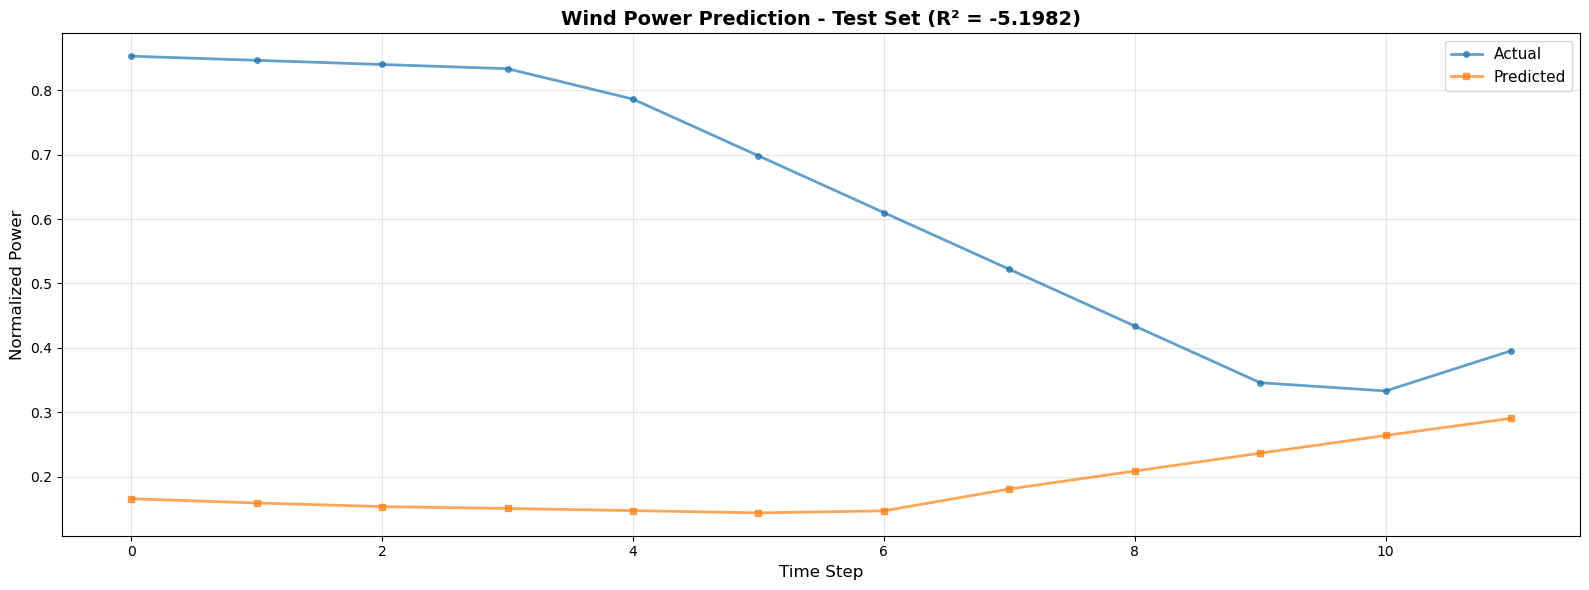

Full prediction plot saved!


In [27]:
# Plot full test predictions
plt.figure(figsize=(16, 6))
plt.plot(actual_test[:200], label='Actual', marker='o', linewidth=2, markersize=4, alpha=0.7)
plt.plot(predictions_np[:200], label='Predicted', marker='s', linewidth=2, markersize=4, alpha=0.7)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Normalized Power', fontsize=12)
plt.title(f'Wind Power Prediction - Test Set (R² = {r2:.4f})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('full_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Full prediction plot saved!")

In [28]:
# Extract 12-hour ahead predictions
prediction_length = 12
num_samples = len(predictions_np) // prediction_length

predictions_12h = predictions_np[:num_samples * prediction_length].reshape(-1, prediction_length)
actual_12h = actual_test[:num_samples * prediction_length].reshape(-1, prediction_length)

# Calculate metrics for each hour
hourly_r2 = []
hourly_rmse = []

for hour in range(prediction_length):
    h_r2 = r2_score(actual_12h[:, hour], predictions_12h[:, hour])
    h_rmse = np.sqrt(mean_squared_error(actual_12h[:, hour], predictions_12h[:, hour]))
    hourly_r2.append(h_r2)
    hourly_rmse.append(h_rmse)

print("\nHourly Performance (12 hours ahead):")
print("=" * 50)
print(f"{'Hour':<8} {'R² Score':<15} {'RMSE':<15}")
print("=" * 50)
for hour in range(prediction_length):
    print(f"{hour+1:<8} {hourly_r2[hour]:<15.6f} {hourly_rmse[hour]:<15.6f}")
print("=" * 50)
print(f"Average: {np.mean(hourly_r2):<15.6f} {np.mean(hourly_rmse):<15.6f}")


Hourly Performance (12 hours ahead):
Hour     R² Score        RMSE           
1        nan             0.686807       
2        nan             0.686845       
3        nan             0.686052       
4        nan             0.682393       
5        nan             0.638509       
6        nan             0.554077       
7        nan             0.462822       
8        nan             0.340949       
9        nan             0.225057       
10       nan             0.109325       
11       nan             0.069076       
12       nan             0.104801       
Average: nan             0.437226       


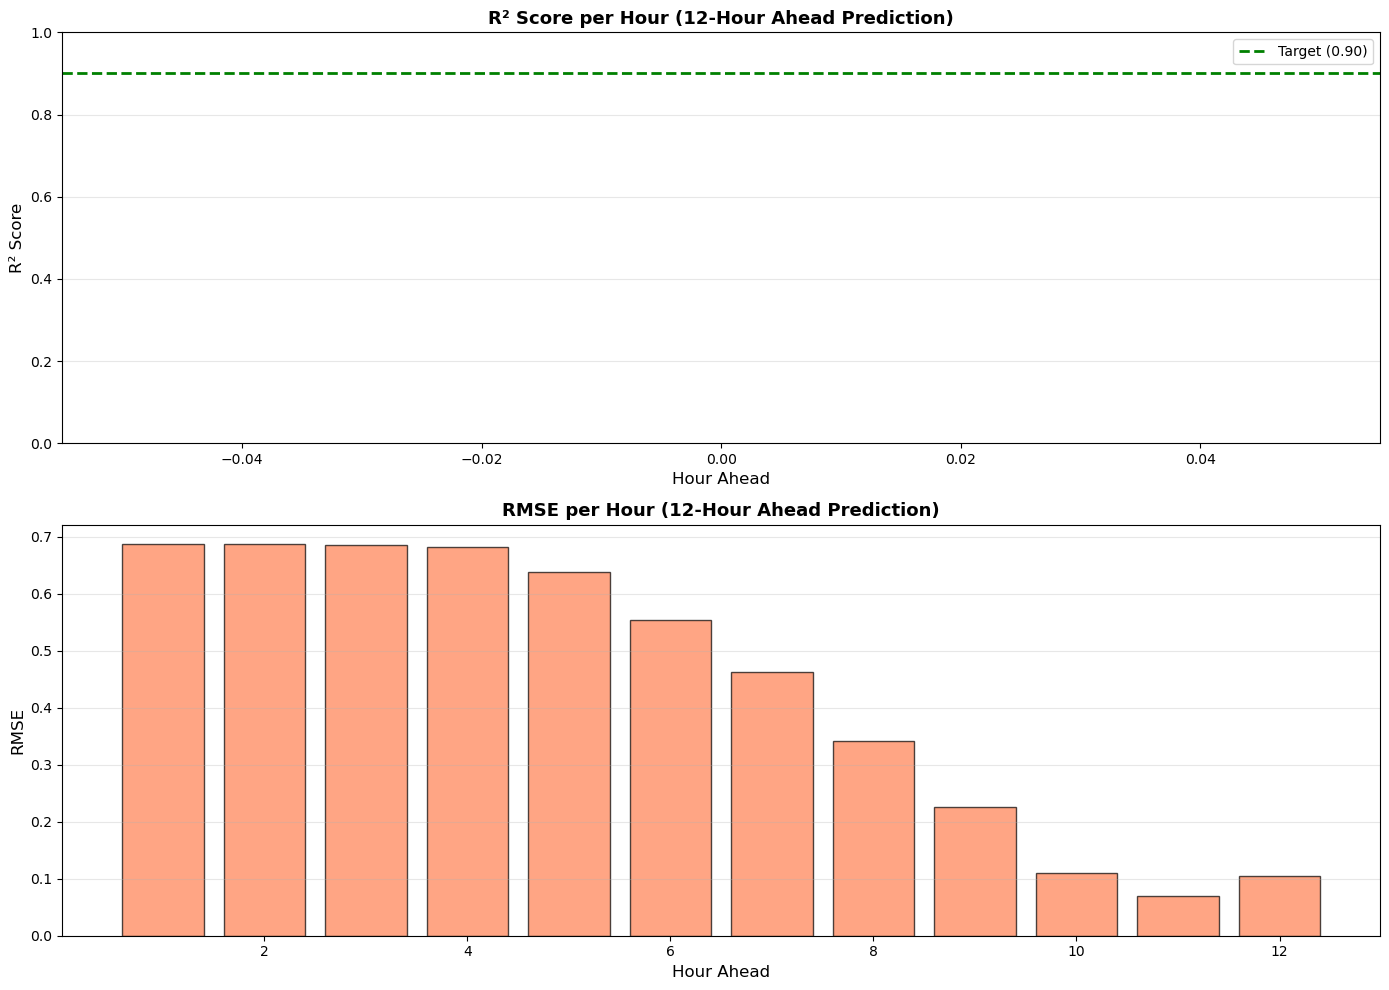

Hourly metrics plot saved!


In [29]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: R² Score per hour
axes[0].bar(range(1, prediction_length + 1), hourly_r2, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=0.90, color='green', linestyle='--', linewidth=2, label='Target (0.90)')
axes[0].set_xlabel('Hour Ahead', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score per Hour (12-Hour Ahead Prediction)', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: RMSE per hour
axes[1].bar(range(1, prediction_length + 1), hourly_rmse, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Hour Ahead', fontsize=12)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('RMSE per Hour (12-Hour Ahead Prediction)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('hourly_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hourly metrics plot saved!")

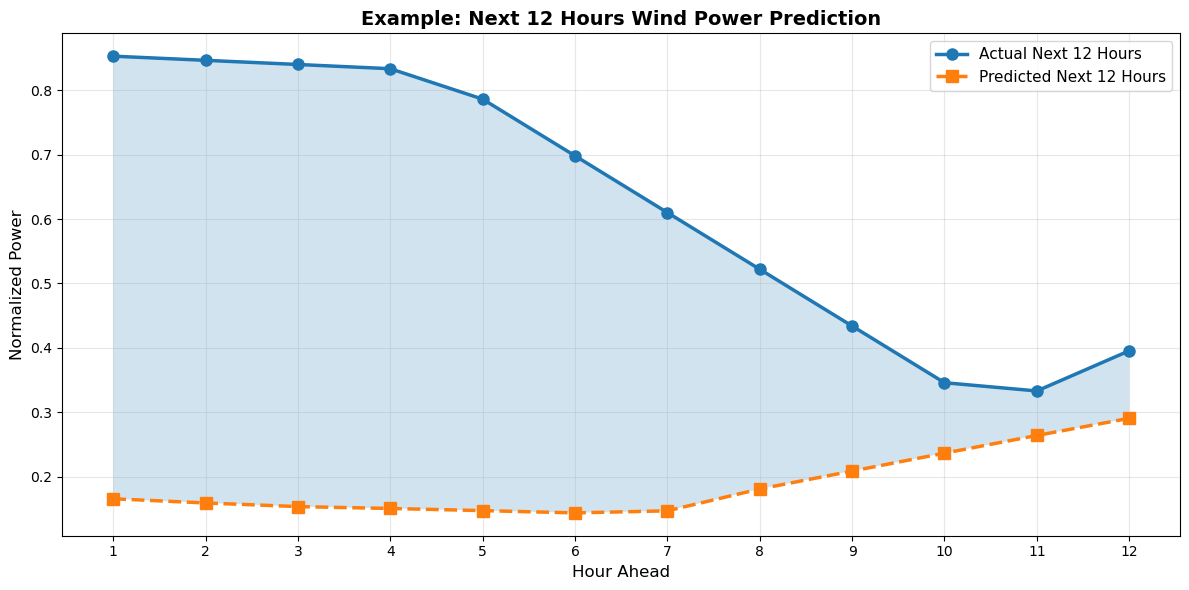


Detailed 12-Hour Prediction:
Hour     Actual Power         Predicted Power      Error          
1        0.852719             0.165912             0.686807       
2        0.846262             0.159417             0.686845       
3        0.839806             0.153754             0.686052       
4        0.833249             0.150856             0.682393       
5        0.786039             0.147530             0.638509       
6        0.698073             0.143997             0.554077       
7        0.610007             0.147185             0.462822       
8        0.522042             0.181092             0.340949       
9        0.433976             0.208919             0.225057       
10       0.346010             0.236685             0.109325       
11       0.333199             0.264123             0.069076       
12       0.395541             0.290740             0.104801       

✓ Training and prediction completed successfully!
✓ Model saved to: wind_power_tft_model.pkl


In [30]:
# Get the last available data point for making a fresh prediction
last_48_hours = data.iloc[-48:].copy()

# Extract predictions for the last sample
last_predictions = predictions_np[-prediction_length:]
last_actual = actual_test[-prediction_length:]

# Plot
plt.figure(figsize=(12, 6))
hours = np.arange(1, prediction_length + 1)
plt.plot(hours, last_actual, 'o-', label='Actual Next 12 Hours', linewidth=2.5, markersize=8)
plt.plot(hours, last_predictions, 's--', label='Predicted Next 12 Hours', linewidth=2.5, markersize=8)
plt.fill_between(hours, last_actual, last_predictions, alpha=0.2)
plt.xlabel('Hour Ahead', fontsize=12)
plt.ylabel('Normalized Power', fontsize=12)
plt.title('Example: Next 12 Hours Wind Power Prediction', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(hours)
plt.tight_layout()
plt.savefig('next_12_hours_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed table
print("\nDetailed 12-Hour Prediction:")
print("=" * 70)
print(f"{'Hour':<8} {'Actual Power':<20} {'Predicted Power':<20} {'Error':<15}")
print("=" * 70)
for h in range(prediction_length):
    error = last_actual[h] - last_predictions[h]
    print(f"{h+1:<8} {last_actual[h]:<20.6f} {last_predictions[h]:<20.6f} {error:<15.6f}")
print("=" * 70)

print("\n✓ Training and prediction completed successfully!")
print(f"✓ Model saved to: {model_path}")